# Kaggle 2018 Data Science Bowl

## Predictions using a simple Convolutional Neural Network

In [1]:
# import the necessary packages
from glob import glob
import imageio
import numpy as np

from keras.preprocessing.image import img_to_array
import os
import pandas as pd
import pathlib
import skimage

from skimage import data, filters, io, transform
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.io import imread
from scipy import ndimage

import matplotlib.pyplot as plt
%matplotlib inline


//anaconda/envs/keras/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# class DataPrep:  loading and preparing the data for a stage

Looks at stage1 by default.

In [2]:

use_saved_weights = True

IMG_CHANNELS = 3

def read_and_stack(in_img_list):
    return np.sum(np.stack([imread(c_img) for c_img in in_img_list], 0), 0)/255.0

class DataPrep:
    
    def __init__(self, data_directory = os.path.join('..', 'data'), stage_label = 'stage1'):
        self.data_dir = data_directory
        self.stage_label = stage_label
        self.train_labels = None
        self.img_df = None
        self.train_img_df = None

    def load_stage_properties(self, verbose = False):
        # Create a DataFrame containing all stage image (both training and test, both images and masks) paths, 
        #   IDs, and properties
        all_images = glob(os.path.join(self.data_dir, '{}_*'.format(self.stage_label), '*', '*', '*'))
        self.img_df = pd.DataFrame({'path': all_images})
        img_id = lambda in_path: in_path.split('/')[-3]
        img_type = lambda in_path: in_path.split('/')[-2]
        img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
        img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
        self.img_df['ImageId'] = self.img_df['path'].map(img_id)
        self.img_df['ImageType'] = self.img_df['path'].map(img_type)
        self.img_df['TrainingSplit'] = self.img_df['path'].map(img_group)
        self.img_df['Stage'] = self.img_df['path'].map(img_stage)
        if verbose:
            print(self.img_df.sample(2))
                
    def load_training_labels(self, verbose = False):
        # Read the training labels from CSV
        self.train_labels = pd.read_csv(os.path.join(self.data_dir,'{}_train_labels.csv'.format(self.stage_label)))
        # Turn the encoded pixels into Python lists
        self.train_labels['EncodedPixels'] = self.train_labels['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
        if verbose:
            print(self.train_labels.sample(3))

    def load_training_images(self, verbose = False):
        # This may take a minute...
        # Get the images in the training split
        train_df = self.img_df.query('TrainingSplit=="train"')
        self.train_rows = []
        group_cols = ['Stage', 'ImageId']
        i = 0
        for n_group, n_rows in train_df.groupby(group_cols):
#             print('n_group={0}, n_rows={1}'.format(n_group, n_rows))
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['masks'] = n_rows.query('ImageType == "masks"')['path'].values.tolist()
#             print('len(masks)={}'.format(len(c_row['masks'])))
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
#             print(c_row['images'])
            self.train_rows += [c_row]
        self.train_img_df = pd.DataFrame(self.train_rows) # so far, images and masks are lists of paths
        # The following reads the images into arrays, drops the Alpha channel, and divides each 0-255 intensity by 255
        self.train_img_df['images'] = self.train_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
        # The following reads the masks and creates a single mask array per image with entries 0 and 1
        self.train_img_df['masks'] = self.train_img_df['masks'].map(read_and_stack).map(lambda x: x.astype(int))
#         print('images.shape={0}, masks.shape={1}'.format(self.train_img_df['images'], self.train_img_df['masks']))
        if verbose:
            print(self.train_img_df.sample(1))
        
    def display_sample_images(self):
        # Display some samples
        n_img = 6
        fig, m_axs = plt.subplots(2, n_img, figsize = (12, 4))
        for (_, c_row), (c_im, c_lab) in zip(self.train_img_df.sample(n_img).iterrows(), 
                                             m_axs.T):
            c_im.imshow(c_row['images'])
            c_im.axis('off')
            c_im.set_title('Image')

            c_lab.imshow(c_row['masks'])
            c_lab.axis('off')
            c_lab.set_title('Masks')
    
    def count_training_image_shapes(self):
        print(self.train_img_df['images'].map(lambda x: x.shape).value_counts())

    def load_stage2_test_data(self, verbose = False):
        # Add stage2 test images to the DataFrame
        all_images2 = glob(os.path.join(self.data_dir, 'stage2_*', '*', '*', '*'))
        img_df2 = pd.DataFrame({'path': all_images2})
        img_id = lambda in_path: in_path.split('/')[-3]
        img_type = lambda in_path: in_path.split('/')[-2]
        img_group = lambda in_path: in_path.split('/')[-4].split('_')[1]
        img_stage = lambda in_path: in_path.split('/')[-4].split('_')[0]
        img_df2['ImageId'] = img_df2['path'].map(img_id)
        img_df2['ImageType'] = img_df2['path'].map(img_type)
        img_df2['TrainingSplit'] = img_df2['path'].map(img_group)
        img_df2['Stage'] = img_df2['path'].map(img_stage)
        combo = self.img_df.append(img_df2)
        self.img_df = combo
        if verbose:
            print(self.img_df.sample(5))

### Load the Stage1 data

### First, training labels

In [3]:
dp = DataPrep()
dp.load_training_labels(verbose=True)

                                                 ImageId  \
4542   20e209f6ffa120a72712e1b4c1d3e24d1339227e2936ab...   
25995  df53d0b6c2c4e45d759b2c474011e2b2b32552cd100ca4...   
8447   45cc00f2ef95da6698bf590663e319d7c0ed4fb99d42dd...   

                                           EncodedPixels  
4542   [310121, 8, 310631, 12, 311142, 15, 311653, 17...  
25995  [15853, 3, 16112, 5, 16372, 5, 16632, 5, 16892...  
8447   [126361, 1, 126721, 3, 127081, 4, 127441, 6, 1...  


### Load ImageIds, paths, etc.

In [4]:
dp.load_stage_properties(verbose=False)

### A sample row of the image properties dataframe

In [5]:
dp.img_df.iloc[2]

path             ../data/stage1_test/5cee644e5ffbef1ba021c7f389...
ImageId          5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3ed...
ImageType                                                   images
TrainingSplit                                                 test
Stage                                                       stage1
Name: 2, dtype: object

### Load the training images and masks
This takes a minute...

In [6]:
dp.load_training_images(verbose=True)

                                               ImageId   Stage  \
340  7f38885521586fc6011bef1314a9fb2aa1e4935bd581b2...  stage1   

                                                images  \
340  [[[0.8117647058823529, 0.8117647058823529, 0.8...   

                                                 masks  
340  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...  


### Sample images and masks

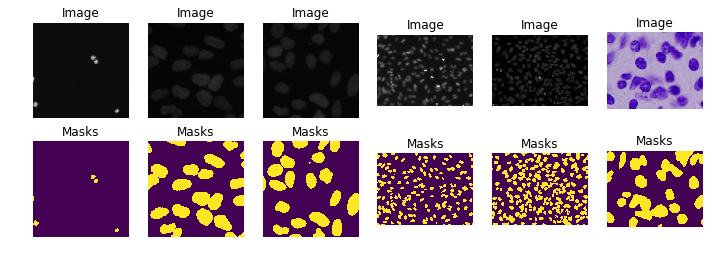

In [22]:
dp.display_sample_images()

### Counts of shapes for the training images

In [8]:
dp.count_training_image_shapes()

(256, 256, 3)      334
(256, 320, 3)      112
(520, 696, 3)       92
(360, 360, 3)       91
(1024, 1024, 3)     16
(512, 640, 3)       13
(603, 1272, 3)       6
(260, 347, 3)        5
(1040, 1388, 3)      1
Name: images, dtype: int64


### A few sample rows of the images dataframe

In [9]:
dp.train_img_df.sample(3)

,ImageId,Stage,images,masks
650,f8e74d4006dd68c1dbe68df7be905835e00d8ba4916f3b...,stage1,"[[[0.00784313725490196, 0.00784313725490196, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
273,62057502c387145ed4f8f7f0d5e5bedcb72d3bcec15fa7...,stage1,"[[[0.00784313725490196, 0.00784313725490196, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
50,139946af9e2c7ef4f0298e622b831dbef5e5c0cd088eb5...,stage1,"[[[0.01568627450980392, 0.01568627450980392, 0...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


### The images column of the dataframe contains 3-channel arrays with intensities normalized to the range 0-1. The masks column contains one binary array per image with the masks marked.

In [10]:
print(dp.train_img_df['images'][2].shape)
print(dp.train_img_df['masks'][2].shape)

(256, 320, 3)
(256, 320)


### How to query for a specific image's properties

In [11]:
dp.img_df.query('TrainingSplit == "train"' and 
                'ImageId == "00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e"')

,path,ImageId,ImageType,TrainingSplit,Stage
7558,../data/stage1_train/00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,images,train,stage1
7559,../data/stage1_train/00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
7560,../data/stage1_train/00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
7561,../data/stage1_train/00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
7562,../data/stage1_train/00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
7563,../data/stage1_train/00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
7564,../data/stage1_train/00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
7565,../data/stage1_train/00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
7566,../data/stage1_train/00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1
7567,../data/stage1_train/00ae65c1c6631ae6f2be1a449...,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,masks,train,stage1


### Getting a specific image's image and mask arrays

In [23]:
dp.train_img_df.query('TrainingSplit == "train"' and 
                      'Stage == "stage1"' and
                      'ImageId == "00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e"')

,ImageId,Stage,images,masks
2,00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b074...,stage1,"[[[0.5098039215686274, 0.24313725490196078, 0....","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,..."


# class SimpleCNN:   defining/training/running a simple Convolutional Neural Network for the prediction task.

In [24]:
class SimpleCNN:
    
    def __init__(self):
        self.IMG_CHANNELS = 3
        self.simple_cnn = None
        self.test_img_df = None

    def define_keras_model(self, verbose = False):
        # Set up a fairly simple Keras CNN
        from keras import backend as K
        from keras.models import Sequential
        from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
        self.simple_cnn = Sequential()
        self.simple_cnn.add(BatchNormalization(input_shape = (None, None, self.IMG_CHANNELS), 
                                          name = 'NormalizeInput'))
        self.simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))
        self.simple_cnn.add(Conv2D(8, kernel_size = (3,3), padding = 'same'))

        # use dilations to get a slightly larger field of view
        self.simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
        self.simple_cnn.add(Conv2D(16, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
        self.simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

        # the final processing
        self.simple_cnn.add(Conv2D(16, kernel_size = (1,1), padding = 'same'))
        self.simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
        if verbose:
            print(self.simple_cnn.summary())
            
        smooth = 1.

        def dice_coef(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)
            return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

        def dice_coef_loss(y_true, y_pred):
            return -dice_coef(y_true, y_pred)

        self.simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])

    def define_keras_model_2(self, verbose = False):
        # Set up a Keras CNN, slightly larger than the first model
        from keras import backend as K
        from keras.models import Sequential
        from keras.layers import BatchNormalization, Conv2D, UpSampling2D, Lambda
        self.simple_cnn = Sequential()
        self.simple_cnn.add(BatchNormalization(input_shape = (None, None, self.IMG_CHANNELS), 
                                          name = 'NormalizeInput'))
        self.simple_cnn.add(Conv2D(16, kernel_size = (3,3), padding = 'same'))
        self.simple_cnn.add(Conv2D(16, kernel_size = (3,3), padding = 'same'))

        # use dilations to get a slightly larger field of view
        self.simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
        self.simple_cnn.add(Conv2D(32, kernel_size = (3,3), dilation_rate = 2, padding = 'same'))
        self.simple_cnn.add(Conv2D(64, kernel_size = (3,3), dilation_rate = 3, padding = 'same'))

        # the final processing
        self.simple_cnn.add(Conv2D(32, kernel_size = (1,1), padding = 'same'))
        self.simple_cnn.add(Conv2D(1, kernel_size = (1,1), padding = 'same', activation = 'sigmoid'))
        if verbose:
            print(self.simple_cnn.summary())
            
        smooth = 1.

        def dice_coef(y_true, y_pred):
            y_true_f = K.flatten(y_true)
            y_pred_f = K.flatten(y_pred)
            intersection = K.sum(y_true_f * y_pred_f)
            return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

        def dice_coef_loss(y_true, y_pred):
            return -dice_coef(y_true, y_pred)

        self.simple_cnn.compile(optimizer = 'adam', 
                   loss = dice_coef_loss, 
                   metrics = [dice_coef, 'acc', 'mse'])
    
    def learn_the_model(self, train_img_df, use_saved_weights = False, epochs = 3):
        def simple_gen():
            while True:
                for _, c_row in train_img_df.iterrows():
                    yield np.expand_dims(c_row['images'],0), np.expand_dims(np.expand_dims(c_row['masks'],-1),0)

        # Learn the model 
        if not use_saved_weights:
            # This takes a while...
            self.simple_cnn.fit_generator(simple_gen(), 
                                     steps_per_epoch = train_img_df.shape[0],
                                     epochs = epochs)
            
    def save_weights(self, filename = 'keras_weights.h5'):
        # Save the model so we don't have to retrain it to use it
        import h5py
        from keras.models import load_model
        self.simple_cnn.save_weights(filename)
        
    def load_saved_weights(self, filename = 'keras_weights.h5'):
        import h5py
        from keras.models import load_model
        self.simple_cnn.load_weights(filename)
        
#     def prep_stage2_tests(self, img_df):
#         # Prepare to run the stage2 tests
#         test_df = img_df.query('TrainingSplit=="test" and Stage=="stage2"')
#         test_rows = []
#         group_cols = ['Stage', 'ImageId']
#         for n_group, n_rows in test_df.groupby(group_cols):
#             c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
#             c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
#             # One image has only one intensity channel, which will cause read_and_stack to fail.
#             # Until I can fix that, I'll just take it out of the mix. I'll add a dummy entry for
#             #  it in the submission CSV file. Won't affect the score much.
#             if '646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0' not in c_row['images'][0]:
#                 test_rows += [c_row]

#         self.test_img_df = pd.DataFrame(test_rows)    
#         self.test_img_df['images'] = self.test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
        
#     def run_stage2_tests(self):
#         # This takes almost 15 minutes...
#         # Generate the model's predictions for the stage2 test images
#         self.test_img_df['masks'] = self.test_img_df['images'].map(lambda x: simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])        
                
    def prep_stage_tests(self, img_df, stage_label):
        # Prepare to run the tests
        test_df = img_df.query('TrainingSplit=="test" and Stage=="{}"'.format(stage_label))
        test_rows = []
        group_cols = ['Stage', 'ImageId']
        for n_group, n_rows in test_df.groupby(group_cols):
            c_row = {col_name: col_value for col_name, col_value in zip(group_cols, n_group)}
            c_row['images'] = n_rows.query('ImageType == "images"')['path'].values.tolist()
            # One image has only one intensity channel, which will cause read_and_stack to fail.
            # Until I can fix that, I'll just take it out of the mix. I'll add a dummy entry for
            #  it in the submission CSV file. Won't affect the score much.
#             print(c_row['images'])
            if len(c_row['images']) == 0:
                continue
            if '646f5e00a2db3add97fb80a83ef3c07edd1b17b1b0d47c2bd650cdcab9f322c0' not in c_row['images'][0]:
                test_rows += [c_row]

        self.test_img_df = pd.DataFrame(test_rows)    
        self.test_img_df['images'] = self.test_img_df['images'].map(read_and_stack).map(lambda x: x[:,:,:IMG_CHANNELS])
        
    def run_stage_tests(self):
        # This takes almost 15 minutes...
        # Assumes you've run prep_stage_tests for the stage of interest.
        # Generate the model's predictions for the stage's test images.
        self.test_img_df['masks'] = self.test_img_df['images'].map(lambda x: self.simple_cnn.predict(np.expand_dims(x, 0))[0, :, :, 0])
    

In [25]:
test_df = dp.img_df.query('TrainingSplit=="test" and Stage=="stage1"')
test_df.shape

(65, 5)

### Create the CNN model

In [26]:
cnn = SimpleCNN()
cnn.define_keras_model(verbose=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NormalizeInput (BatchNormali (None, None, None, 3)     12        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, None, None, 8)     224       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, None, None, 8)     584       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, None, None, 16)    1168      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 32)    4640      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, None, None, 16)    528       
__________

### Learn the model

This takes a while.
After learning, save the weights, which can then be used on subsequent runs to skip the training step, e.g., to try out different post-processing steps.

In [18]:
%%time
use_saved_weights = False
if not use_saved_weights:
    cnn.learn_the_model(dp.train_img_df, use_saved_weights=False, epochs=3)

Epoch 1/3
670/670 [==============================] - 390s 583ms/step - loss: -0.7441 - dice_coef: 0.7441 - acc: 0.9069 - mean_squared_error: 0.0826
Epoch 2/3
670/670 [==============================] - 411s 614ms/step - loss: -0.8010 - dice_coef: 0.8010 - acc: 0.9321 - mean_squared_error: 0.0656
Epoch 3/3
670/670 [==============================] - 422s 630ms/step - loss: -0.8066 - dice_coef: 0.8066 - acc: 0.9328 - mean_squared_error: 0.0655
CPU times: user 51min 7s, sys: 28min 18s, total: 1h 19min 26s
Wall time: 20min 24s


### Save the weights

In [19]:
if not use_saved_weights:
    cnn.save_weights('simple_cnn_weights_v1_3_epochs.h5')

### Load saved weights

In [27]:
use_saved_weights = True
if use_saved_weights:
    cnn.load_saved_weights('simple_cnn_weights_v1_3_epochs.h5')

### Prepare data for a prediction run

In [28]:
cnn.prep_stage_tests(dp.img_df, 'stage1')

### Do a prediction run

In [29]:
%%time
cnn.run_stage_tests()

CPU times: user 33.5 s, sys: 22.7 s, total: 56.2 s
Wall time: 12.7 s


In [30]:
cnn.test_img_df.sample(1)

,ImageId,Stage,images,masks
15,295682d9eb5acb5c1976a460c085734bfaf38482b0a3f0...,stage1,"[[[0.047058823529411764, 0.047058823529411764,...","[[4.630876e-21, 8.6878545e-23, 3.1793804e-27, ..."


# class PostProcess:  post-process the results of a prediction run

In [31]:
%matplotlib inline
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import skimage.segmentation
from skimage.morphology import closing, opening, disk
from skimage.morphology import label # to label regions

class PostProcess:
    
    def __init__(self):
        pass
    
    def clean_img(self, img):
        return opening(closing(img, disk(1)), disk(3))

    def clean_test_results(self, test_img_df):
        # This can take a little while...
        test_img_df['rles'] = test_img_df['masks'].map(self.clean_img).map(lambda x: list(self.prob_to_rles(x))) 
        return test_img_df
    
    def display_samples_cleaned(self, test_img_df):
        n_img = 3
        fig, m_axs = plt.subplots(3, n_img, figsize = (12, 6))
        for (_, d_row), (c_im, c_lab, c_clean) in zip(test_img_df.sample(n_img).iterrows(), 
                                     m_axs):
            c_im.imshow(d_row['images'])
            c_im.axis('off')
            c_im.set_title('Image')

            c_lab.imshow(d_row['masks'])
            c_lab.axis('off')
            c_lab.set_title('Predicted')

            c_clean.imshow(self.clean_img(d_row['masks']))
            c_clean.axis('off')
            c_clean.set_title('Cleaned')    

    def rle_encoding(self, x):
        '''
        x: numpy array of shape (height, width), 1 - mask, 0 - background
        Returns run length as list
        '''
        dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right, which is what Kaggle expects
        run_lengths = []
        prev = -2
        for b in dots:
            if (b > prev+1): run_lengths.extend((b+1, 0))
            run_lengths[-1] += 1
            prev = b
        return run_lengths

    def prob_to_rles(self, x, cut_off = 0.5):
        lab_img = label(x > cut_off)
        if lab_img.max() < 1:
            lab_img[0,0] = 1 # ensure at least one prediction per image
        for i in range(1, lab_img.max() + 1):
            yield self.rle_encoding(lab_img == i)
    
    def save_predictions_file(self, test_img_df, outfile='predictions.csv'):
        out_pred_list = []
        for _, c_row in test_img_df.iterrows():
            # The model may make a prediction that consists of the entire image
            # kaggle's scoring algorithm fails on such predictions.
            # We'll replace them with a smaller prediction. That will also be wrong, but at least it won't
            #  cause kaggle scoring to fail.
            if len(c_row['rles']) == 1:
                s = c_row['images'].shape
                img_size = s[0] * s[1]
                if c_row['rles'][0][0] == 1 and c_row['rles'][0][1] == img_size:
                    c_row['rles'] = [[int(img_size/2), int(10)]]
            for c_rle in c_row['rles']:
                out_pred_list+=[dict(ImageId=c_row['ImageId'], 
                                     EncodedPixels = ' '.join(np.array(c_rle).astype(str)))]
        out_pred_df = pd.DataFrame(out_pred_list)
        print(out_pred_df.shape[0], 'regions found for', test_img_df.shape[0], 'images')
        out_pred_df.sample(3)
        out_pred_df[['ImageId', 'EncodedPixels']].to_csv(outfile, index = False)

### Post-process a run

In [32]:
pp = PostProcess()
cnn.test_img_df = pp.clean_test_results(cnn.test_img_df)
cnn.test_img_df.sample(1)

,ImageId,Stage,images,masks,rles
17,336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a96...,stage1,"[[[0.09019607843137255, 0.09019607843137255, 0...","[[5.7992056e-15, 3.3291857e-16, 3.5320428e-20,...","[[23881, 4, 24398, 8, 24916, 11, 25433, 14, 25..."


### Sample predictions and cleaned images

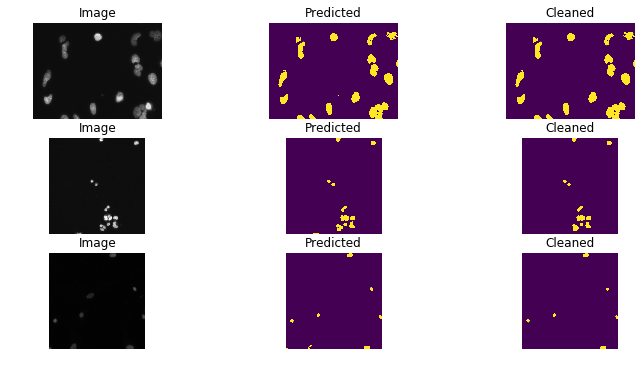

In [33]:
pp.display_samples_cleaned(cnn.test_img_df)

### Save the predictions file in Kaggle format

In [34]:
pp.save_predictions_file(cnn.test_img_df, 'predictions_v1_3_epochs.csv')

1591 regions found for 65 images


# class KaggleScorer:   Scoring a run

In [35]:
import skimage
import skimage.segmentation

class KaggleScorer:
    
    def __init__(self, test_img_df, data_directory = os.path.join('..', 'data'), stage_label = 'stage1'):
        self.data_dir = data_directory
        self.stage_label = stage_label
        self.test_img_df = test_img_df
    
    def load_ground_truth_masks(self, verbose = False):
        # Read the masks from CSV 
        self.true_masks = pd.read_csv(os.path.join(self.data_dir,'{}_solution.csv'.format(self.stage_label)))
        # Turn the encoded pixels into Python lists
        self.true_masks['EncodedPixels'] = self.true_masks['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
        if verbose:
            print(self.true_masks.sample(3))

    def load_predicted_masks(self, filepath, verbose = False):
        # Read the masks from CSV 
        self.predicted_masks = pd.read_csv(filepath)
        # Turn the encoded pixels into Python lists
        self.predicted_masks['EncodedPixels'] = self.predicted_masks['EncodedPixels'].map(lambda ep: [int(x) for x in ep.split(' ')])
        if verbose:
            print(self.predicted_masks.sample(3))
    
    def create_mask_image_from_RLE(self, masks, height, width):
        img = np.zeros((height, width), np.uint16).flatten()
        mask_num = 1
        for _, m_row in masks.iterrows():
            rle = m_row['EncodedPixels']
            index = 0
            for i in range(int(len(rle) / 2)):
                where = rle[index] - 1 # indices sent to Kaggle are 1-based
                length = rle[index+1]
#                 print('  where={0}, length={1}'.format(where, length))
                for j in range(length):
                    img[where + j] = mask_num
                index += 2
            mask_num += 1
        img = img.reshape(width, height).T  # RLE uses Fortran order
        return img            

    def score_an_image(self, image_id, verbose = False):
        # Assumes we've run load_ground_truth_masks and load_predicted_masks
        if verbose:
            print()
            print('ImageId={}'.format(image_id))
        masks = ks.true_masks.query('ImageId == "{}"'.format(image_id))
        height = masks.iloc[0]['Height']
        width = masks.iloc[0]['Width']
#         print('height=', height, ' width=', width)
        true_img = ks.create_mask_image_from_RLE(masks, height, width)

        pred_masks = ks.predicted_masks.query('ImageId == "{}"'.format(image_id))
        pred_img = ks.create_mask_image_from_RLE(pred_masks, height, width)
        if verbose:
            plt.subplot(1, 3, 1)
            img = self.test_img_df.query('ImageId == "{}"'.format(image_id))['images'].iloc[0]
            plt.imshow(img)
            plt.axis('off')
            plt.title(' Original Image')
            plt.subplot(1, 3, 2)
            plt.imshow(true_img)
            plt.axis('off')
            plt.title('Ground Truth')
            plt.subplot(1, 3, 3)
            plt.imshow(pred_img)
            plt.axis('off')
            plt.title('Predictions')
            plt.show()            

        # Compute number of objects
        true_objects = len(np.unique(true_img))
        pred_objects = len(np.unique(pred_img))
        if verbose:
            print("Number of true objects:", true_objects)
            print("Number of predicted objects:", pred_objects)

        # Compute intersection between all objects
        intersection = np.histogram2d(true_img.flatten(), pred_img.flatten(), bins=(true_objects, pred_objects))[0]

        # Compute areas (needed for finding the union between all objects)
        area_true = np.histogram(true_img, bins = true_objects)[0]
        area_pred = np.histogram(pred_img, bins = pred_objects)[0]
        area_true = np.expand_dims(area_true, -1)
        area_pred = np.expand_dims(area_pred, 0)

        # Compute union
        union = area_true + area_pred - intersection

        # Exclude background from the analysis
        intersection = intersection[1:,1:]
        union = union[1:,1:]
        union[union == 0] = 1e-9

        # Compute the intersection over union
        iou = intersection / union
#         print('iou={}'.format(iou))

        # Precision helper function
        def precision_at(threshold, iou):
            matches = iou > threshold
            true_positives = np.sum(matches, axis=1) == 1   # Correct objects
            false_positives = np.sum(matches, axis=0) == 0  # Missed objects
            false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
            tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
            return tp, fp, fn

        # Loop over IoU thresholds
        prec = []
        if verbose:
            print("Thresh\tTP\tFP\tFN\tPrec.")
        for t in np.arange(0.5, 1.0, 0.05):
            tp, fp, fn = precision_at(t, iou)
            p = tp / (tp + fp + fn)
            if verbose:
                print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
            prec.append(p)
        if verbose:
            print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
        return np.mean(prec)
    
    def score_a_run(self, verbose = False):
        precisions = []
        for n_group, _ in ks.true_masks.groupby(['ImageId']):
            precisions.append(self.score_an_image(n_group, verbose=verbose))
        mean_prec = sum(precisions) / float(len(precisions))
        if verbose:
            print('Kaggle score = {0:.3f}'.format(mean_prec))
        return mean_prec

            

### Load the ground truth masks and predicted masks into the KaggleScorer

In [36]:
ks = KaggleScorer(cnn.test_img_df)
ks.load_ground_truth_masks()
ks.load_predicted_masks('predictions_v1_3_epochs.csv')

### How to retrieve and display ground truth masks for an image

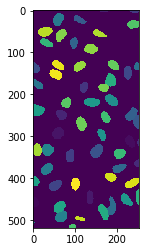

In [37]:
masks = ks.true_masks.query('ImageId == "0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac"')
height = masks.iloc[0]['Height']
width = masks.iloc[0]['Width']
mask_img = ks.create_mask_image_from_RLE(masks, height, width)
plt.imshow(mask_img)

### How to retrieve and display predictions for an image

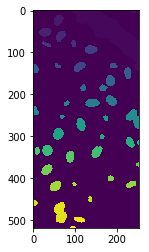

In [38]:
masks = ks.predicted_masks.query('ImageId == "0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac"')
# same height and width as true_masks image
mask_img = ks.create_mask_image_from_RLE(masks, height, width)
plt.imshow(mask_img)

### Compute the Kaggle score for an image

Note: there is no relationship between the colors in the two mask images. It's just the locations of the masks that matter. 


ImageId=0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732


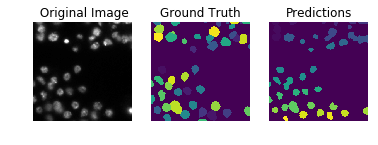

Number of true objects: 51
Number of predicted objects: 37
Thresh	TP	FP	FN	Prec.
0.500	31	5	19	0.564
0.550	27	9	23	0.458
0.600	20	16	30	0.303
0.650	14	22	36	0.194
0.700	10	26	40	0.132
0.750	5	31	45	0.062
0.800	4	32	46	0.049
0.850	0	36	50	0.000
0.900	0	36	50	0.000
0.950	0	36	50	0.000
AP	-	-	-	0.176


In [39]:
score = ks.score_an_image('0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732', verbose=True)

### Compute the overall Kaggle score for a run


ImageId=0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5


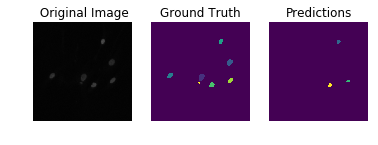

Number of true objects: 8
Number of predicted objects: 4
Thresh	TP	FP	FN	Prec.
0.500	2	1	5	0.250
0.550	2	1	5	0.250
0.600	1	2	6	0.111
0.650	1	2	6	0.111
0.700	1	2	6	0.111
0.750	0	3	7	0.000
0.800	0	3	7	0.000
0.850	0	3	7	0.000
0.900	0	3	7	0.000
0.950	0	3	7	0.000
AP	-	-	-	0.083

ImageId=0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac


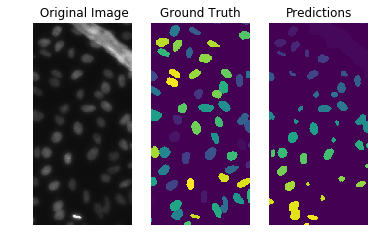

Number of true objects: 60
Number of predicted objects: 44
Thresh	TP	FP	FN	Prec.
0.500	25	18	34	0.325
0.550	23	20	36	0.291
0.600	20	23	39	0.244
0.650	20	23	39	0.244
0.700	20	23	39	0.244
0.750	16	27	43	0.186
0.800	6	37	53	0.062
0.850	0	43	59	0.000
0.900	0	43	59	0.000
0.950	0	43	59	0.000
AP	-	-	-	0.160

ImageId=0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732


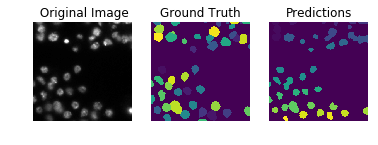

Number of true objects: 51
Number of predicted objects: 37
Thresh	TP	FP	FN	Prec.
0.500	31	5	19	0.564
0.550	27	9	23	0.458
0.600	20	16	30	0.303
0.650	14	22	36	0.194
0.700	10	26	40	0.132
0.750	5	31	45	0.062
0.800	4	32	46	0.049
0.850	0	36	50	0.000
0.900	0	36	50	0.000
0.950	0	36	50	0.000
AP	-	-	-	0.176

ImageId=0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925


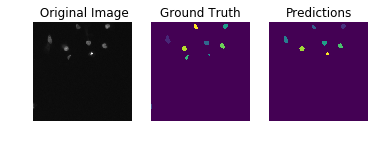

Number of true objects: 10
Number of predicted objects: 8
Thresh	TP	FP	FN	Prec.
0.500	6	1	3	0.600
0.550	6	1	3	0.600
0.600	6	1	3	0.600
0.650	6	1	3	0.600
0.700	6	1	3	0.600
0.750	5	2	4	0.455
0.800	4	3	5	0.333
0.850	2	5	7	0.143
0.900	0	7	9	0.000
0.950	0	7	9	0.000
AP	-	-	-	0.393

ImageId=0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6


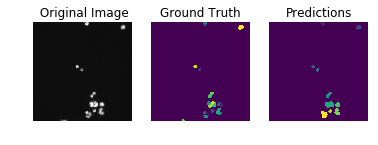

Number of true objects: 22
Number of predicted objects: 11
Thresh	TP	FP	FN	Prec.
0.500	5	5	16	0.192
0.550	4	6	17	0.148
0.600	4	6	17	0.148
0.650	4	6	17	0.148
0.700	4	6	17	0.148
0.750	4	6	17	0.148
0.800	4	6	17	0.148
0.850	2	8	19	0.069
0.900	0	10	21	0.000
0.950	0	10	21	0.000
AP	-	-	-	0.115

ImageId=0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466


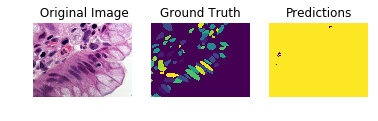

Number of true objects: 71
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	70	0.000
0.550	0	1	70	0.000
0.600	0	1	70	0.000
0.650	0	1	70	0.000
0.700	0	1	70	0.000
0.750	0	1	70	0.000
0.800	0	1	70	0.000
0.850	0	1	70	0.000
0.900	0	1	70	0.000
0.950	0	1	70	0.000
AP	-	-	-	0.000

ImageId=1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c


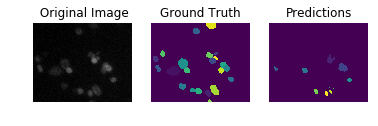

Number of true objects: 23
Number of predicted objects: 11
Thresh	TP	FP	FN	Prec.
0.500	5	5	17	0.185
0.550	4	6	18	0.143
0.600	3	7	19	0.103
0.650	2	8	20	0.067
0.700	1	9	21	0.032
0.750	1	9	21	0.032
0.800	1	9	21	0.032
0.850	1	9	21	0.032
0.900	0	10	22	0.000
0.950	0	10	22	0.000
AP	-	-	-	0.063

ImageId=17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff


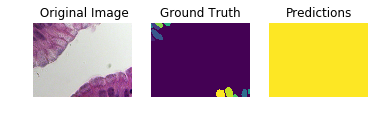

Number of true objects: 12
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	11	0.000
0.550	0	1	11	0.000
0.600	0	1	11	0.000
0.650	0	1	11	0.000
0.700	0	1	11	0.000
0.750	0	1	11	0.000
0.800	0	1	11	0.000
0.850	0	1	11	0.000
0.900	0	1	11	0.000
0.950	0	1	11	0.000
AP	-	-	-	0.000

ImageId=1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b


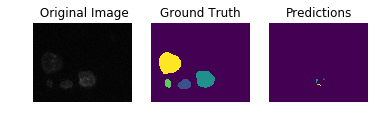

Number of true objects: 5
Number of predicted objects: 5
Thresh	TP	FP	FN	Prec.
0.500	0	4	4	0.000
0.550	0	4	4	0.000
0.600	0	4	4	0.000
0.650	0	4	4	0.000
0.700	0	4	4	0.000
0.750	0	4	4	0.000
0.800	0	4	4	0.000
0.850	0	4	4	0.000
0.900	0	4	4	0.000
0.950	0	4	4	0.000
AP	-	-	-	0.000

ImageId=191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829


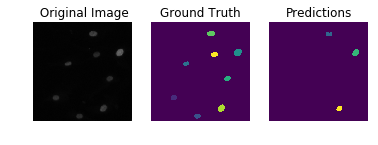

Number of true objects: 9
Number of predicted objects: 4
Thresh	TP	FP	FN	Prec.
0.500	3	0	5	0.375
0.550	3	0	5	0.375
0.600	3	0	5	0.375
0.650	2	1	6	0.222
0.700	1	2	7	0.100
0.750	1	2	7	0.100
0.800	1	2	7	0.100
0.850	0	3	8	0.000
0.900	0	3	8	0.000
0.950	0	3	8	0.000
AP	-	-	-	0.165

ImageId=1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a


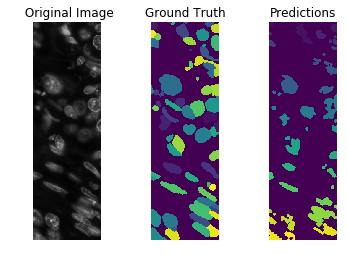

Number of true objects: 76
Number of predicted objects: 42
Thresh	TP	FP	FN	Prec.
0.500	16	25	59	0.160
0.550	9	32	66	0.084
0.600	7	34	68	0.064
0.650	5	36	70	0.045
0.700	0	41	75	0.000
0.750	0	41	75	0.000
0.800	0	41	75	0.000
0.850	0	41	75	0.000
0.900	0	41	75	0.000
0.950	0	41	75	0.000
AP	-	-	-	0.035

ImageId=1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e


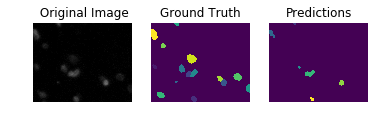

Number of true objects: 16
Number of predicted objects: 7
Thresh	TP	FP	FN	Prec.
0.500	1	5	14	0.050
0.550	1	5	14	0.050
0.600	1	5	14	0.050
0.650	1	5	14	0.050
0.700	1	5	14	0.050
0.750	0	6	15	0.000
0.800	0	6	15	0.000
0.850	0	6	15	0.000
0.900	0	6	15	0.000
0.950	0	6	15	0.000
AP	-	-	-	0.025

ImageId=1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1


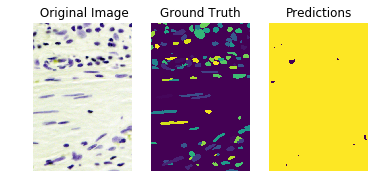

Number of true objects: 116
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	115	0.000
0.550	0	1	115	0.000
0.600	0	1	115	0.000
0.650	0	1	115	0.000
0.700	0	1	115	0.000
0.750	0	1	115	0.000
0.800	0	1	115	0.000
0.850	0	1	115	0.000
0.900	0	1	115	0.000
0.950	0	1	115	0.000
AP	-	-	-	0.000

ImageId=1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c


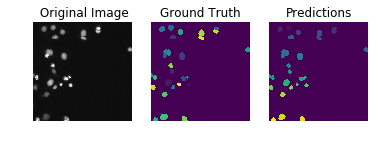

Number of true objects: 31
Number of predicted objects: 23
Thresh	TP	FP	FN	Prec.
0.500	20	2	10	0.625
0.550	19	3	11	0.576
0.600	19	3	11	0.576
0.650	17	5	13	0.486
0.700	16	6	14	0.444
0.750	15	7	15	0.405
0.800	12	10	18	0.300
0.850	7	15	23	0.156
0.900	2	20	28	0.040
0.950	0	22	30	0.000
AP	-	-	-	0.361

ImageId=259b35151d4a7a5ffdd7ab7f171b142db8cfe40beeee67277fac6adca4d042c4


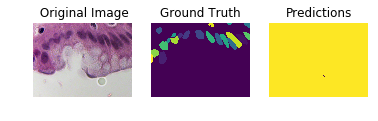

Number of true objects: 24
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	23	0.000
0.550	0	1	23	0.000
0.600	0	1	23	0.000
0.650	0	1	23	0.000
0.700	0	1	23	0.000
0.750	0	1	23	0.000
0.800	0	1	23	0.000
0.850	0	1	23	0.000
0.900	0	1	23	0.000
0.950	0	1	23	0.000
AP	-	-	-	0.000

ImageId=295682d9eb5acb5c1976a460c085734bfaf38482b0a3f02591c2bfdcd4128549


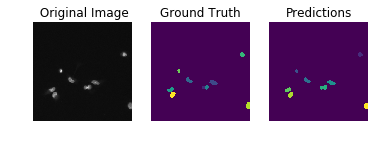

Number of true objects: 10
Number of predicted objects: 9
Thresh	TP	FP	FN	Prec.
0.500	8	0	1	0.889
0.550	7	1	2	0.700
0.600	7	1	2	0.700
0.650	7	1	2	0.700
0.700	7	1	2	0.700
0.750	7	1	2	0.700
0.800	6	2	3	0.545
0.850	5	3	4	0.417
0.900	3	5	6	0.214
0.950	0	8	9	0.000
AP	-	-	-	0.557

ImageId=31f1fbe85b8899258ea5bcf5f93f7ac8238660c386aeab40649c715bd2e38a0a


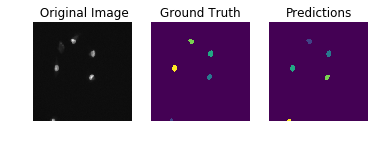

Number of true objects: 6
Number of predicted objects: 6
Thresh	TP	FP	FN	Prec.
0.500	5	0	0	1.000
0.550	5	0	0	1.000
0.600	5	0	0	1.000
0.650	5	0	0	1.000
0.700	5	0	0	1.000
0.750	5	0	0	1.000
0.800	5	0	0	1.000
0.850	4	1	1	0.667
0.900	1	4	4	0.111
0.950	0	5	5	0.000
AP	-	-	-	0.778

ImageId=336d3e4105766f8ad328a7ee9571e743f376f8cbcf6a969ca7e353fe3235c523


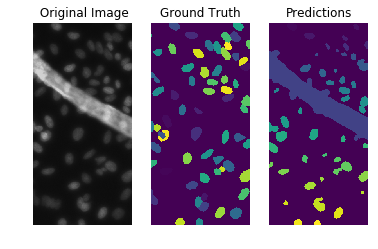

Number of true objects: 67
Number of predicted objects: 47
Thresh	TP	FP	FN	Prec.
0.500	25	21	41	0.287
0.550	24	22	42	0.273
0.600	17	29	49	0.179
0.650	15	31	51	0.155
0.700	13	33	53	0.131
0.750	10	36	56	0.098
0.800	5	41	61	0.047
0.850	0	46	66	0.000
0.900	0	46	66	0.000
0.950	0	46	66	0.000
AP	-	-	-	0.117

ImageId=38f5cfb55fc8b048e82a5c895b25fefae7a70c71ab9990c535d1030637bf6a1f


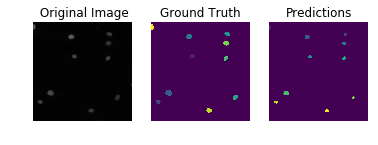

Number of true objects: 11
Number of predicted objects: 11
Thresh	TP	FP	FN	Prec.
0.500	6	4	4	0.429
0.550	4	6	6	0.250
0.600	4	6	6	0.250
0.650	3	7	7	0.176
0.700	3	7	7	0.176
0.750	1	9	9	0.053
0.800	0	10	10	0.000
0.850	0	10	10	0.000
0.900	0	10	10	0.000
0.950	0	10	10	0.000
AP	-	-	-	0.133

ImageId=3c4c675825f7509877bc10497f498c9a2e3433bf922bd870914a2eb21a54fd26


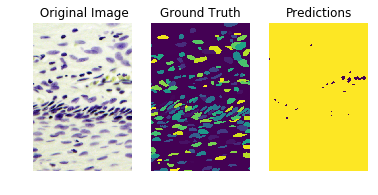

Number of true objects: 206
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	205	0.000
0.550	0	1	205	0.000
0.600	0	1	205	0.000
0.650	0	1	205	0.000
0.700	0	1	205	0.000
0.750	0	1	205	0.000
0.800	0	1	205	0.000
0.850	0	1	205	0.000
0.900	0	1	205	0.000
0.950	0	1	205	0.000
AP	-	-	-	0.000

ImageId=432f367a4c5b5674de2e2977744d10289a064e5704b21af6607b4975be47c580


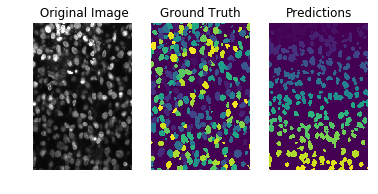

Number of true objects: 330
Number of predicted objects: 140
Thresh	TP	FP	FN	Prec.
0.500	86	53	243	0.225
0.550	75	64	254	0.191
0.600	62	77	267	0.153
0.650	49	90	280	0.117
0.700	38	101	291	0.088
0.750	26	113	303	0.059
0.800	12	127	317	0.026
0.850	3	136	326	0.006
0.900	0	139	329	0.000
0.950	0	139	329	0.000
AP	-	-	-	0.087

ImageId=43a71aeb641faa18742cb826772a8566c6c947d7050f9ab15459de6cc2b3b6af


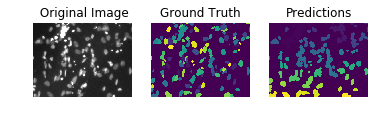

Number of true objects: 135
Number of predicted objects: 59
Thresh	TP	FP	FN	Prec.
0.500	38	20	96	0.247
0.550	32	26	102	0.200
0.600	30	28	104	0.185
0.650	29	29	105	0.178
0.700	26	32	108	0.157
0.750	22	36	112	0.129
0.800	17	41	117	0.097
0.850	11	47	123	0.061
0.900	3	55	131	0.016
0.950	0	58	134	0.000
AP	-	-	-	0.127

ImageId=44afae184c89e6ba55985b4d341acc1ae1e8b6ef96312064e0e6e630e022b078


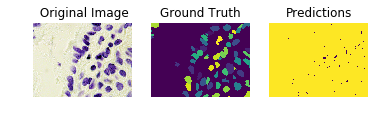

Number of true objects: 72
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	71	0.000
0.550	0	1	71	0.000
0.600	0	1	71	0.000
0.650	0	1	71	0.000
0.700	0	1	71	0.000
0.750	0	1	71	0.000
0.800	0	1	71	0.000
0.850	0	1	71	0.000
0.900	0	1	71	0.000
0.950	0	1	71	0.000
AP	-	-	-	0.000

ImageId=4727d94c6a57ed484270fdd8bbc6e3d5f2f15d5476794a4e37a40f2309a091e2


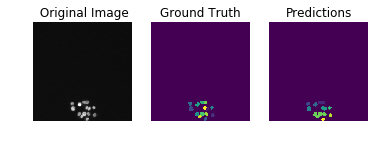

Number of true objects: 15
Number of predicted objects: 10
Thresh	TP	FP	FN	Prec.
0.500	7	2	7	0.438
0.550	6	3	8	0.353
0.600	6	3	8	0.353
0.650	6	3	8	0.353
0.700	6	3	8	0.353
0.750	5	4	9	0.278
0.800	5	4	9	0.278
0.850	1	8	13	0.045
0.900	0	9	14	0.000
0.950	0	9	14	0.000
AP	-	-	-	0.245

ImageId=472b1c5ff988dadc209faea92499bc07f305208dbda29d16262b3d543ac91c71


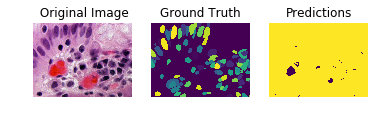

Number of true objects: 92
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	91	0.000
0.550	0	1	91	0.000
0.600	0	1	91	0.000
0.650	0	1	91	0.000
0.700	0	1	91	0.000
0.750	0	1	91	0.000
0.800	0	1	91	0.000
0.850	0	1	91	0.000
0.900	0	1	91	0.000
0.950	0	1	91	0.000
AP	-	-	-	0.000

ImageId=4be73d68f433869188fe5e7f09c7f681ed51003da6aa5d19ce368726d8e271ee


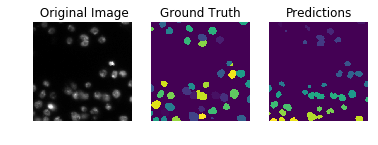

Number of true objects: 46
Number of predicted objects: 36
Thresh	TP	FP	FN	Prec.
0.500	25	10	20	0.455
0.550	24	11	21	0.429
0.600	23	12	22	0.404
0.650	19	16	26	0.311
0.700	9	26	36	0.127
0.750	2	33	43	0.026
0.800	0	35	45	0.000
0.850	0	35	45	0.000
0.900	0	35	45	0.000
0.950	0	35	45	0.000
AP	-	-	-	0.175

ImageId=4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc48c97f105bee4f8fac


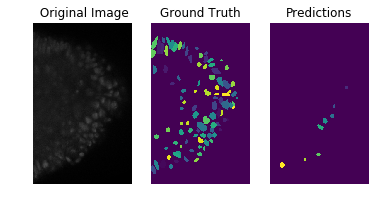

Number of true objects: 99
Number of predicted objects: 9
Thresh	TP	FP	FN	Prec.
0.500	2	6	96	0.019
0.550	2	6	96	0.019
0.600	0	8	98	0.000
0.650	0	8	98	0.000
0.700	0	8	98	0.000
0.750	0	8	98	0.000
0.800	0	8	98	0.000
0.850	0	8	98	0.000
0.900	0	8	98	0.000
0.950	0	8	98	0.000
AP	-	-	-	0.004

ImageId=505bc0a3928d8aef5ce441c5a611fdd32e1e8eccdc15cc3a52b88030acb50f81


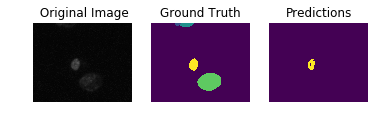

Number of true objects: 5
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	1	0	3	0.250
0.550	1	0	3	0.250
0.600	1	0	3	0.250
0.650	1	0	3	0.250
0.700	0	1	4	0.000
0.750	0	1	4	0.000
0.800	0	1	4	0.000
0.850	0	1	4	0.000
0.900	0	1	4	0.000
0.950	0	1	4	0.000
AP	-	-	-	0.100

ImageId=519dc0d672d1c295fc69b629af8721ccb1a1f136d1976685a68487e62547ffe0


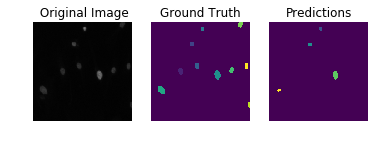

Number of true objects: 11
Number of predicted objects: 5
Thresh	TP	FP	FN	Prec.
0.500	3	1	7	0.273
0.550	3	1	7	0.273
0.600	2	2	8	0.167
0.650	2	2	8	0.167
0.700	2	2	8	0.167
0.750	2	2	8	0.167
0.800	1	3	9	0.077
0.850	0	4	10	0.000
0.900	0	4	10	0.000
0.950	0	4	10	0.000
AP	-	-	-	0.129

ImageId=51c70bb8a299943b27f8b354571272692d8f2705036a1a9562156c76da5f025b


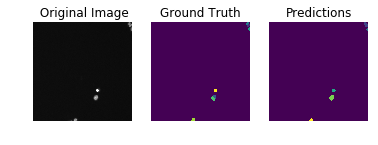

Number of true objects: 8
Number of predicted objects: 6
Thresh	TP	FP	FN	Prec.
0.500	5	0	2	0.714
0.550	3	2	4	0.333
0.600	3	2	4	0.333
0.650	3	2	4	0.333
0.700	3	2	4	0.333
0.750	3	2	4	0.333
0.800	3	2	4	0.333
0.850	3	2	4	0.333
0.900	1	4	6	0.091
0.950	0	5	7	0.000
AP	-	-	-	0.314

ImageId=52b267e20519174e3ce1e1994b5d677804b16bc670aa5f6ffb6344a0fdf63fde


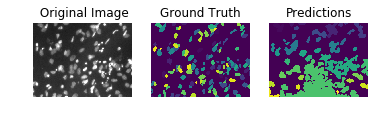

Number of true objects: 147
Number of predicted objects: 40
Thresh	TP	FP	FN	Prec.
0.500	22	17	124	0.135
0.550	18	21	128	0.108
0.600	15	24	131	0.088
0.650	14	25	132	0.082
0.700	12	27	134	0.069
0.750	9	30	137	0.051
0.800	7	32	139	0.039
0.850	2	37	144	0.011
0.900	1	38	145	0.005
0.950	0	39	146	0.000
AP	-	-	-	0.059

ImageId=53df5150ee56253fe5bc91a9230d377bb21f1300f443ba45a758bcb01a15c0e4


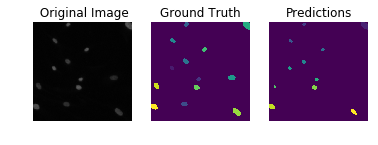

Number of true objects: 14
Number of predicted objects: 12
Thresh	TP	FP	FN	Prec.
0.500	10	1	3	0.714
0.550	9	2	4	0.600
0.600	5	6	8	0.263
0.650	3	8	10	0.143
0.700	2	9	11	0.091
0.750	2	9	11	0.091
0.800	1	10	12	0.043
0.850	1	10	12	0.043
0.900	0	11	13	0.000
0.950	0	11	13	0.000
AP	-	-	-	0.199

ImageId=550450e4bff4036fd671decdc5d42fec23578198d6a2fd79179c4368b9d6da18


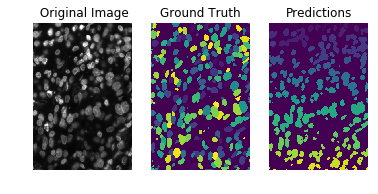

Number of true objects: 265
Number of predicted objects: 124
Thresh	TP	FP	FN	Prec.
0.500	75	48	189	0.240
0.550	68	55	196	0.213
0.600	64	59	200	0.198
0.650	55	68	209	0.166
0.700	41	82	223	0.118
0.750	31	92	233	0.087
0.800	22	101	242	0.060
0.850	13	110	251	0.035
0.900	3	120	261	0.008
0.950	0	123	264	0.000
AP	-	-	-	0.113

ImageId=5cee644e5ffbef1ba021c7f389b33bafd3b1841f04d3edd7922d5084c2c4e0c7


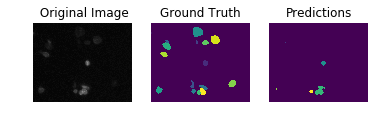

Number of true objects: 17
Number of predicted objects: 7
Thresh	TP	FP	FN	Prec.
0.500	2	4	14	0.100
0.550	2	4	14	0.100
0.600	2	4	14	0.100
0.650	2	4	14	0.100
0.700	1	5	15	0.048
0.750	1	5	15	0.048
0.800	0	6	16	0.000
0.850	0	6	16	0.000
0.900	0	6	16	0.000
0.950	0	6	16	0.000
AP	-	-	-	0.050

ImageId=648c8ffa496e1716017906d0bf135debfc93386ae86aa3d4adbda9a505985fd9


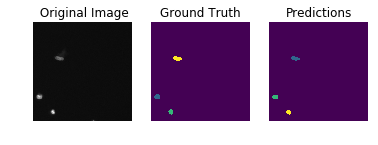

Number of true objects: 4
Number of predicted objects: 4
Thresh	TP	FP	FN	Prec.
0.500	3	0	0	1.000
0.550	3	0	0	1.000
0.600	3	0	0	1.000
0.650	3	0	0	1.000
0.700	3	0	0	1.000
0.750	3	0	0	1.000
0.800	2	1	1	0.500
0.850	1	2	2	0.200
0.900	1	2	2	0.200
0.950	0	3	3	0.000
AP	-	-	-	0.690

ImageId=697a05c6fe4a07c601d46da80885645ad574ea19b47ee795ccff216c9f1f1808


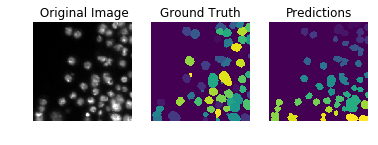

Number of true objects: 61
Number of predicted objects: 35
Thresh	TP	FP	FN	Prec.
0.500	23	11	37	0.324
0.550	20	14	40	0.270
0.600	19	15	41	0.253
0.650	15	19	45	0.190
0.700	9	25	51	0.106
0.750	9	25	51	0.106
0.800	3	31	57	0.033
0.850	0	34	60	0.000
0.900	0	34	60	0.000
0.950	0	34	60	0.000
AP	-	-	-	0.128

ImageId=699f2992cd71e2e28cf45f81347ff22e76b37541ce88087742884cd0e9aadc68


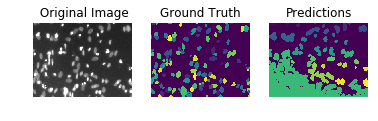

Number of true objects: 130
Number of predicted objects: 41
Thresh	TP	FP	FN	Prec.
0.500	24	16	105	0.166
0.550	22	18	107	0.150
0.600	19	21	110	0.127
0.650	17	23	112	0.112
0.700	13	27	116	0.083
0.750	11	29	118	0.070
0.800	7	33	122	0.043
0.850	2	38	127	0.012
0.900	0	40	129	0.000
0.950	0	40	129	0.000
AP	-	-	-	0.076

ImageId=78a981bd27ba0c65a9169548665a17bda9f49050d0d3893a6567d1eb92cd003d


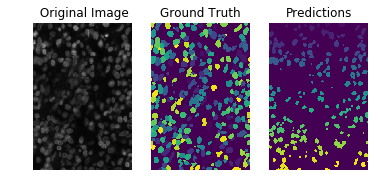

Number of true objects: 312
Number of predicted objects: 151
Thresh	TP	FP	FN	Prec.
0.500	74	76	237	0.191
0.550	51	99	260	0.124
0.600	42	108	269	0.100
0.650	34	116	277	0.080
0.700	18	132	293	0.041
0.750	10	140	301	0.022
0.800	6	144	305	0.013
0.850	1	149	310	0.002
0.900	0	150	311	0.000
0.950	0	150	311	0.000
AP	-	-	-	0.057

ImageId=7bdb668e6127b7eafc837a883f0648002bd063c736f55a4f673e787250a3fb04


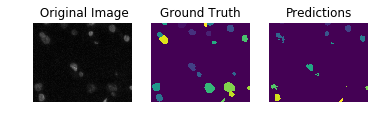

Number of true objects: 22
Number of predicted objects: 16
Thresh	TP	FP	FN	Prec.
0.500	9	6	12	0.333
0.550	8	7	13	0.286
0.600	8	7	13	0.286
0.650	8	7	13	0.286
0.700	8	7	13	0.286
0.750	6	9	15	0.200
0.800	4	11	17	0.125
0.850	2	13	19	0.059
0.900	0	15	21	0.000
0.950	0	15	21	0.000
AP	-	-	-	0.186

ImageId=7f4cbe0b36b5d09466476a7d4e01f4f976c67872d549f4ff47b3e1e3a2b403af


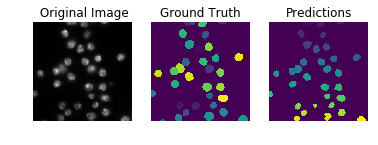

Number of true objects: 35
Number of predicted objects: 32
Thresh	TP	FP	FN	Prec.
0.500	29	2	5	0.806
0.550	29	2	5	0.806
0.600	26	5	8	0.667
0.650	25	6	9	0.625
0.700	21	10	13	0.477
0.750	14	17	20	0.275
0.800	6	25	28	0.102
0.850	3	28	31	0.048
0.900	0	31	34	0.000
0.950	0	31	34	0.000
AP	-	-	-	0.380

ImageId=8922a6ac8fd0258ec27738ca101867169b20d90a60fc84f93df77acd5bf7c80b


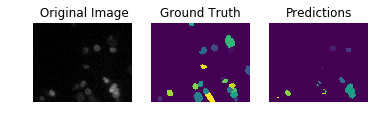

Number of true objects: 22
Number of predicted objects: 12
Thresh	TP	FP	FN	Prec.
0.500	4	7	17	0.143
0.550	3	8	18	0.103
0.600	3	8	18	0.103
0.650	2	9	19	0.067
0.700	1	10	20	0.032
0.750	0	11	21	0.000
0.800	0	11	21	0.000
0.850	0	11	21	0.000
0.900	0	11	21	0.000
0.950	0	11	21	0.000
AP	-	-	-	0.045

ImageId=8b59819fbc92eefe45b1db95c0cc3a467ddcfc755684c7f2ba2f6ccb9ad740ab


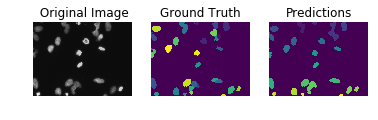

Number of true objects: 39
Number of predicted objects: 26
Thresh	TP	FP	FN	Prec.
0.500	23	2	15	0.575
0.550	22	3	16	0.537
0.600	20	5	18	0.465
0.650	20	5	18	0.465
0.700	19	6	19	0.432
0.750	17	8	21	0.370
0.800	16	9	22	0.340
0.850	11	14	27	0.212
0.900	8	17	30	0.145
0.950	1	24	37	0.016
AP	-	-	-	0.356

ImageId=912a679e4b9b1d1a75170254fd675b8c24b664d80ad7ea7e460241a23535a406


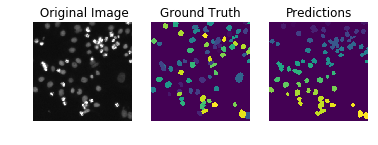

Number of true objects: 79
Number of predicted objects: 55
Thresh	TP	FP	FN	Prec.
0.500	46	8	32	0.535
0.550	44	10	34	0.500
0.600	42	12	36	0.467
0.650	41	13	37	0.451
0.700	41	13	37	0.451
0.750	39	15	39	0.419
0.800	27	27	51	0.257
0.850	15	39	63	0.128
0.900	5	49	73	0.039
0.950	0	54	78	0.000
AP	-	-	-	0.325

ImageId=9ab2d381f90b485a68b82bc07f94397a0373e3215ad20935a958738e55f3cfc2


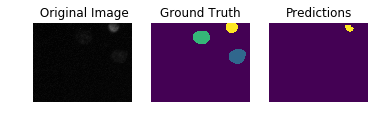

Number of true objects: 4
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	3	0.000
0.550	0	1	3	0.000
0.600	0	1	3	0.000
0.650	0	1	3	0.000
0.700	0	1	3	0.000
0.750	0	1	3	0.000
0.800	0	1	3	0.000
0.850	0	1	3	0.000
0.900	0	1	3	0.000
0.950	0	1	3	0.000
AP	-	-	-	0.000

ImageId=9f17aea854db13015d19b34cb2022cfdeda44133323fcd6bb3545f7b9404d8ab


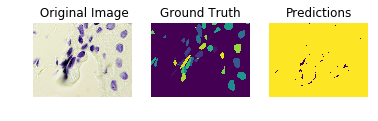

Number of true objects: 45
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	44	0.000
0.550	0	1	44	0.000
0.600	0	1	44	0.000
0.650	0	1	44	0.000
0.700	0	1	44	0.000
0.750	0	1	44	0.000
0.800	0	1	44	0.000
0.850	0	1	44	0.000
0.900	0	1	44	0.000
0.950	0	1	44	0.000
AP	-	-	-	0.000

ImageId=a4816cc1fb76cb3c5e481186833fc0ae9cf426a1406a2607e974e65e9cddba4f


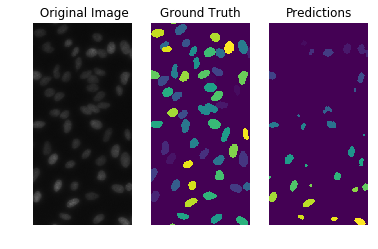

Number of true objects: 59
Number of predicted objects: 30
Thresh	TP	FP	FN	Prec.
0.500	14	15	44	0.192
0.550	14	15	44	0.192
0.600	11	18	47	0.145
0.650	9	20	49	0.115
0.700	8	21	50	0.101
0.750	5	24	53	0.061
0.800	3	26	55	0.036
0.850	0	29	58	0.000
0.900	0	29	58	0.000
0.950	0	29	58	0.000
AP	-	-	-	0.084

ImageId=a984e7fb886aa02e29d112766d3ce26a4f78eac540ce7bbdbd42af2761928f6d


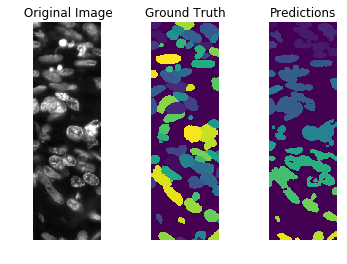

Number of true objects: 74
Number of predicted objects: 28
Thresh	TP	FP	FN	Prec.
0.500	16	11	57	0.190
0.550	16	11	57	0.190
0.600	13	14	60	0.149
0.650	12	15	61	0.136
0.700	11	16	62	0.124
0.750	4	23	69	0.042
0.800	2	25	71	0.020
0.850	0	27	73	0.000
0.900	0	27	73	0.000
0.950	0	27	73	0.000
AP	-	-	-	0.085

ImageId=ab298b962a63e4be9582513aaa84a5e270adba5fd2b16a50e59540524f63c3b8


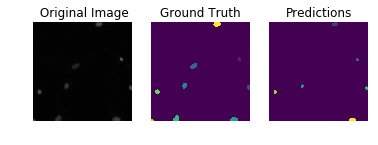

Number of true objects: 10
Number of predicted objects: 7
Thresh	TP	FP	FN	Prec.
0.500	5	1	4	0.500
0.550	5	1	4	0.500
0.600	3	3	6	0.250
0.650	1	5	8	0.071
0.700	1	5	8	0.071
0.750	0	6	9	0.000
0.800	0	6	9	0.000
0.850	0	6	9	0.000
0.900	0	6	9	0.000
0.950	0	6	9	0.000
AP	-	-	-	0.139

ImageId=ade080c6618cbbb0a25680cf847f312b5e19b22bfe1cafec0436987ebe5b1e7e


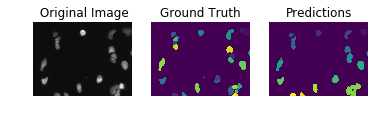

Number of true objects: 31
Number of predicted objects: 17
Thresh	TP	FP	FN	Prec.
0.500	12	4	18	0.353
0.550	12	4	18	0.353
0.600	11	5	19	0.314
0.650	11	5	19	0.314
0.700	10	6	20	0.278
0.750	8	8	22	0.211
0.800	8	8	22	0.211
0.850	8	8	22	0.211
0.900	8	8	22	0.211
0.950	1	15	29	0.022
AP	-	-	-	0.248

ImageId=b83d1d77935b6cfd44105b54600ffc4b6bd82de57dec65571bcb117fa8398ba3


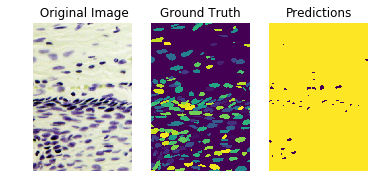

Number of true objects: 220
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	219	0.000
0.550	0	1	219	0.000
0.600	0	1	219	0.000
0.650	0	1	219	0.000
0.700	0	1	219	0.000
0.750	0	1	219	0.000
0.800	0	1	219	0.000
0.850	0	1	219	0.000
0.900	0	1	219	0.000
0.950	0	1	219	0.000
AP	-	-	-	0.000

ImageId=bdc789019cee8ddfae20d5f769299993b4b330b2d38d1218646cf89e77fbbd4d


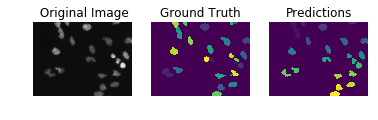

Number of true objects: 29
Number of predicted objects: 22
Thresh	TP	FP	FN	Prec.
0.500	20	1	8	0.690
0.550	20	1	8	0.690
0.600	18	3	10	0.581
0.650	17	4	11	0.531
0.700	16	5	12	0.485
0.750	15	6	13	0.441
0.800	14	7	14	0.400
0.850	13	8	15	0.361
0.900	9	12	19	0.225
0.950	0	21	28	0.000
AP	-	-	-	0.440

ImageId=c8e79ff4ac55f4b772057de28e539727b7f4f2a3de73bf7a082a0ace86d609eb


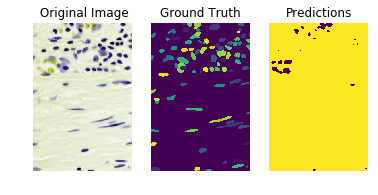

Number of true objects: 99
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	98	0.000
0.550	0	1	98	0.000
0.600	0	1	98	0.000
0.650	0	1	98	0.000
0.700	0	1	98	0.000
0.750	0	1	98	0.000
0.800	0	1	98	0.000
0.850	0	1	98	0.000
0.900	0	1	98	0.000
0.950	0	1	98	0.000
AP	-	-	-	0.000

ImageId=ca20076870e8fb604e61802605a9ac45419c82dd3e23404c56c4869f9502a5ef


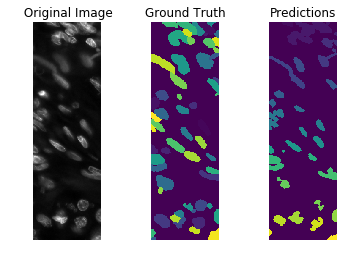

Number of true objects: 61
Number of predicted objects: 31
Thresh	TP	FP	FN	Prec.
0.500	12	18	48	0.154
0.550	10	20	50	0.125
0.600	5	25	55	0.059
0.650	5	25	55	0.059
0.700	2	28	58	0.023
0.750	2	28	58	0.023
0.800	1	29	59	0.011
0.850	1	29	59	0.011
0.900	0	30	60	0.000
0.950	0	30	60	0.000
AP	-	-	-	0.046

ImageId=d616d323a9eeb9da1b66f8d5df671d63c092c9919cb2c0b223e29c63257c944d


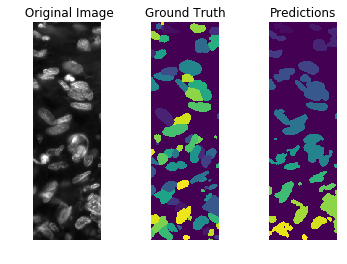

Number of true objects: 82
Number of predicted objects: 30
Thresh	TP	FP	FN	Prec.
0.500	17	12	64	0.183
0.550	14	15	67	0.146
0.600	13	16	68	0.134
0.650	10	19	71	0.100
0.700	8	21	73	0.078
0.750	5	24	76	0.048
0.800	3	26	78	0.028
0.850	1	28	80	0.009
0.900	0	29	81	0.000
0.950	0	29	81	0.000
AP	-	-	-	0.073

ImageId=d6eb7ce7723e2f6dc13b90b41a29ded27dbd815bad633fdf582447c686018896


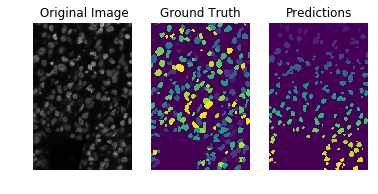

Number of true objects: 250
Number of predicted objects: 149
Thresh	TP	FP	FN	Prec.
0.500	90	58	159	0.293
0.550	84	64	165	0.268
0.600	71	77	178	0.218
0.650	56	92	193	0.164
0.700	41	107	208	0.115
0.750	25	123	224	0.067
0.800	12	136	237	0.031
0.850	3	145	246	0.008
0.900	0	148	249	0.000
0.950	0	148	249	0.000
AP	-	-	-	0.116

ImageId=d8d4bf68a76e4e4c5f21de7ac613451f7115a04db686151e78b8ec0b6a22022b


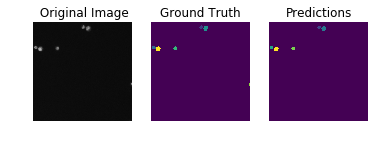

Number of true objects: 7
Number of predicted objects: 6
Thresh	TP	FP	FN	Prec.
0.500	5	0	1	0.833
0.550	5	0	1	0.833
0.600	5	0	1	0.833
0.650	5	0	1	0.833
0.700	5	0	1	0.833
0.750	4	1	2	0.571
0.800	3	2	3	0.375
0.850	0	5	6	0.000
0.900	0	5	6	0.000
0.950	0	5	6	0.000
AP	-	-	-	0.511

ImageId=da6c593410340b19bb212b9f6d274f95b08c0fc8f2570cd66bc5ed42c560acab


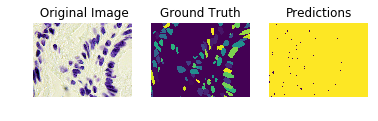

Number of true objects: 92
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	91	0.000
0.550	0	1	91	0.000
0.600	0	1	91	0.000
0.650	0	1	91	0.000
0.700	0	1	91	0.000
0.750	0	1	91	0.000
0.800	0	1	91	0.000
0.850	0	1	91	0.000
0.900	0	1	91	0.000
0.950	0	1	91	0.000
AP	-	-	-	0.000

ImageId=dab46d798d29aff2e99c23f47ed3064f5cafb1644629b015c95a2dd2ee593bb4


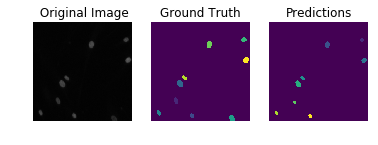

Number of true objects: 10
Number of predicted objects: 9
Thresh	TP	FP	FN	Prec.
0.500	7	1	2	0.700
0.550	7	1	2	0.700
0.600	5	3	4	0.417
0.650	4	4	5	0.308
0.700	3	5	6	0.214
0.750	2	6	7	0.133
0.800	0	8	9	0.000
0.850	0	8	9	0.000
0.900	0	8	9	0.000
0.950	0	8	9	0.000
AP	-	-	-	0.247

ImageId=df40099c6306ca1f47fcc8a62e2fa39486d4e223177afdc51b2ad189691802d8


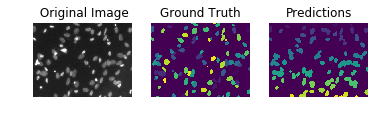

Number of true objects: 98
Number of predicted objects: 60
Thresh	TP	FP	FN	Prec.
0.500	50	9	47	0.472
0.550	49	10	48	0.458
0.600	44	15	53	0.393
0.650	41	18	56	0.357
0.700	37	22	60	0.311
0.750	34	25	63	0.279
0.800	32	27	65	0.258
0.850	24	35	73	0.182
0.900	11	48	86	0.076
0.950	1	58	96	0.006
AP	-	-	-	0.279

ImageId=e17b7aedd251a016c01ef9158e6e4aa940d9f1b35942d86028dc1222192a9258


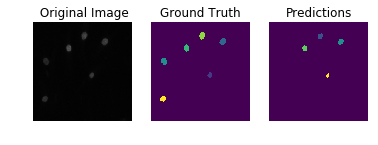

Number of true objects: 7
Number of predicted objects: 5
Thresh	TP	FP	FN	Prec.
0.500	4	0	2	0.667
0.550	4	0	2	0.667
0.600	3	1	3	0.429
0.650	3	1	3	0.429
0.700	2	2	4	0.250
0.750	2	2	4	0.250
0.800	0	4	6	0.000
0.850	0	4	6	0.000
0.900	0	4	6	0.000
0.950	0	4	6	0.000
AP	-	-	-	0.269

ImageId=eea70a7948d25a9a791dbcb39228af4ea4049fe5ebdee9c04884be8cca3da835


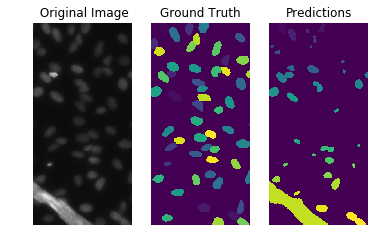

Number of true objects: 56
Number of predicted objects: 34
Thresh	TP	FP	FN	Prec.
0.500	14	19	41	0.189
0.550	13	20	42	0.173
0.600	11	22	44	0.143
0.650	6	27	49	0.073
0.700	5	28	50	0.060
0.750	3	30	52	0.035
0.800	1	32	54	0.011
0.850	0	33	55	0.000
0.900	0	33	55	0.000
0.950	0	33	55	0.000
AP	-	-	-	0.069

ImageId=f0d0ab13ff53adc3c4d57e95a5f83d80b06f2cbc0bf002b52cf7b496612e0ce4


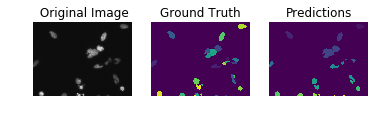

Number of true objects: 35
Number of predicted objects: 20
Thresh	TP	FP	FN	Prec.
0.500	15	4	19	0.395
0.550	12	7	22	0.293
0.600	10	9	24	0.233
0.650	9	10	25	0.205
0.700	8	11	26	0.178
0.750	8	11	26	0.178
0.800	8	11	26	0.178
0.850	6	13	28	0.128
0.900	3	16	31	0.060
0.950	1	18	33	0.019
AP	-	-	-	0.186

ImageId=f5effed21f671bbf4551ecebb7fe95f3be1cf09c16a60afe64d2f0b95be9d1eb


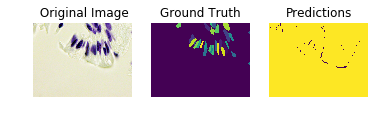

Number of true objects: 32
Number of predicted objects: 2
Thresh	TP	FP	FN	Prec.
0.500	0	1	31	0.000
0.550	0	1	31	0.000
0.600	0	1	31	0.000
0.650	0	1	31	0.000
0.700	0	1	31	0.000
0.750	0	1	31	0.000
0.800	0	1	31	0.000
0.850	0	1	31	0.000
0.900	0	1	31	0.000
0.950	0	1	31	0.000
AP	-	-	-	0.000

ImageId=fac507fa4d1649e8b24c195d990f1fc3ca3633d917839e1751a9d412a14ab5e3


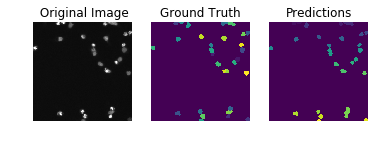

Number of true objects: 33
Number of predicted objects: 26
Thresh	TP	FP	FN	Prec.
0.500	22	3	10	0.629
0.550	22	3	10	0.629
0.600	19	6	13	0.500
0.650	18	7	14	0.462
0.700	17	8	15	0.425
0.750	13	12	19	0.295
0.800	5	20	27	0.096
0.850	1	24	31	0.018
0.900	0	25	32	0.000
0.950	0	25	32	0.000
AP	-	-	-	0.305

ImageId=fe9adb627a6f45747c5a8223b671774791ededf9364f6544be487c540107fa4f


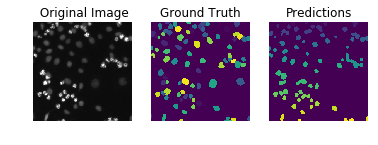

Number of true objects: 89
Number of predicted objects: 65
Thresh	TP	FP	FN	Prec.
0.500	53	11	35	0.535
0.550	47	17	41	0.448
0.600	46	18	42	0.434
0.650	40	24	48	0.357
0.700	29	35	59	0.236
0.750	24	40	64	0.188
0.800	13	51	75	0.094
0.850	4	60	84	0.027
0.900	0	64	88	0.000
0.950	0	64	88	0.000
AP	-	-	-	0.232
Kaggle score = 0.159


0.15899808276258806

In [40]:
ks.score_a_run(verbose=True)

### Get just the overall score

In [41]:
score = ks.score_a_run()
print('Kaggle score = {0:.3f}'.format(score))

Kaggle score = 0.159


In [42]:
ks.true_masks.query('ImageId == "0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466"')

,ImageId,EncodedPixels,Height,Width,Usage
146,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,"[3023, 6, 3535, 8, 4046, 10, 4557, 12, 5068, 1...",512,680,Public
147,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,"[191718, 9, 192227, 15, 192738, 19, 193250, 20...",512,680,Public
148,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,"[55011, 10, 55521, 13, 56031, 16, 56542, 18, 5...",512,680,Public
149,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,"[22971, 6, 23482, 9, 23994, 10, 24506, 12, 250...",512,680,Public
150,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,"[100107, 4, 100618, 7, 101129, 9, 101641, 10, ...",512,680,Public
151,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,"[24802, 5, 25312, 10, 25823, 13, 26333, 16, 26...",512,680,Public
152,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,"[173178, 5, 173690, 7, 174202, 9, 174715, 9, 1...",512,680,Public
153,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,"[45451, 3, 45961, 10, 46472, 13, 46983, 15, 47...",512,680,Public
154,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,"[220968, 9, 221478, 13, 221988, 16, 222499, 17...",512,680,Public
155,0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c0...,"[18550, 3, 19052, 14, 19561, 18, 20071, 20, 20...",512,680,Public


In [43]:
ks.predicted_masks.query('ImageId == "0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5"')

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[45106, 5, 45360, 9, 45615, 10, 45871, 11, 461..."
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[51354, 1, 51608, 5, 51863, 6, 52119, 7, 52374..."
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,"[38822, 1, 39076, 5, 39331, 6, 39585, 9, 39840..."


In [44]:
ks.load_predicted_masks('predictions_v1_3_epochs.csv', verbose=True)

                                                ImageId  \
927   7bdb668e6127b7eafc837a883f0648002bd063c736f55a...   
1162  bdc789019cee8ddfae20d5f769299993b4b330b2d38d12...   
507   4f949bd8d914bbfa06f40d6a0e2b5b75c38bf53dbcbafc...   

                                          EncodedPixels  
927   [185345, 4, 185351, 2, 185857, 10, 186369, 11,...  
1162  [243817, 6, 244329, 16, 244847, 21, 245366, 27...  
507   [43999, 1, 44387, 5, 44776, 6, 45166, 7, 45555...  
